In [1]:
### automatically refresh the buffer

%load_ext autoreload
%autoreload 2

### solve the auto-complete issue

%config Completer.use_jedi = False

### lvl 1 setups

import sys
sys.path.append('/portal1/dell/GitHub/WAYS')
sys.path.append('/portal1/dell/GitHub/sanctuary')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

### lvl 2 setups (systerm)

import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from numpy import hstack
from matplotlib import pyplot
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from statsmodels.regression.quantile_regression import QuantReg
from math import isnan

In [2]:
from numpy import polyfit, poly1d

In [3]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from stats import cr
from gistool import basemap, stack_image, stack_shp, stack_hatch, stack_shp_cn, ncslice
from spatial import upscale
import statsmodels.formula.api as smf
from scipy.stats.mstats import theilslopes
from scipy.stats import kendalltau
import cartopy.crs as ccrs

In [4]:
from enum import Enum
import logging
from typing import Dict

#import numba
import numpy as np
#from climate_indices import compute,indices
import pandas as pd
from standard_precip.lmoments import distr
import pandas as pd
from standard_precip import spi
import statsmodels.formula.api as smf

In [5]:
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [6]:
shp='/portal3/gis/LMRB_Boundary/Lancang_Mekong_Basin/Lancang_Mekong_Basin.shp'
shp2='/portal3/gis/Global_countries/world_map_latest/World_Countries__Generalized_.shp'
shp4='/portal3/gis/Mekong_Delta/mekong_river.shp'

In [8]:
ds_t_dry = xr.open_dataset('monthly_data/LMRB_dryseason_2mt.nc')

In [12]:
ds_uBOB_wet = xr.open_dataset('monthly_data/wetseason_uBOB.nc')
ds_vSCS_wet = xr.open_dataset('monthly_data/wetseason_vSCS.nc')
ds_gphSCS_wet = xr.open_dataset('monthly_data/wetseason_GPH.nc')
ds_t_wet = xr.open_dataset('monthly_data/LMRB_wetseason_2mt.nc')
ds_prec_wet = xr.open_dataset('monthly_data/LMRB_wetseason_prec.nc')

ds_uBOB_dry = xr.open_dataset('monthly_data/dryseason_uBOB.nc')
ds_vSCS_dry = xr.open_dataset('monthly_data/dryseason_vSCS.nc')
ds_gphSCS_dry = xr.open_dataset('monthly_data/dryseason_GPH.nc')
ds_t_dry = xr.open_dataset('monthly_data/LMRB_dryseason_2mt.nc')
ds_prec_dry = xr.open_dataset('monthly_data/LMRB_dryseason_prec.nc')

In [13]:
arr_ubob_wet = ds_uBOB_wet.u.values
arr_vSCS_wet = ds_vSCS_wet.v.values
arr_gphSCS_wet = ds_gphSCS_wet.z.values
arr_t_wet = ds_t_wet.t2m.values
arr_prec_wet = ds_prec_wet.tp.values


arr_ubob_dry = ds_uBOB_dry.u.values
arr_vSCS_dry = ds_vSCS_dry.v.values
arr_gphSCS_dry = ds_gphSCS_dry.z.values
arr_t_dry = ds_t_dry.t2m.values
arr_prec_dry = ds_prec_dry.tp.values

# Quantile regression of wet and dry season precipitation

In [14]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import scipy.stats as st

# wet season array variation construction

In [15]:
wet_season_p = arr_prec_wet
dry_season_p = arr_prec_dry

In [16]:
# normalizaton
prrr_wet = normalization(np.nanmean(wet_season_p,axis=(1,2)))
X_wet = np.column_stack((normalization(np.nanmean(arr_ubob_wet,axis=(1,2))),
                     normalization(np.nanmean(arr_vSCS_wet,axis=(1,2))),
                    normalization(np.nanmean(arr_gphSCS_wet,axis=(1,2))),
                    normalization(np.nanmean(arr_t_wet,axis=(1,2)))))

In [17]:
# Fit the multivariate quantile regression model
#mod = sm.QuantReg(np.nanmean(wet_season_p,axis=(1,2)), sm.add_constant(X))
mod = sm.QuantReg(prrr_wet, sm.add_constant(X_wet))

quantiles = np.arange(0.01,1,0.01)
models = []
params = []
x1_coef,x2_coef,x3_coef,x4_coef = [],[],[],[]
x1_up,x2_up,x3_up,x4_up = [],[],[],[]
x1_down,x2_down,x3_down,x4_down = [],[],[],[]
intercept = []

for qt in quantiles:
    res = mod.fit(q=qt)
    res.params[1:]
    x1_coef.append(res.params[1])
    x2_coef.append(res.params[2])
    x3_coef.append(res.params[3])
    x4_coef.append(res.params[4])
    intercept.append(res.params[0])
    
    x1_up.append(res.conf_int()[1][0])
    x2_up.append(res.conf_int()[2][0])
    x3_up.append(res.conf_int()[3][0])
    x4_up.append(res.conf_int()[4][0])
    
    x1_down.append(res.conf_int()[1][1])
    x2_down.append(res.conf_int()[2][1])
    x3_down.append(res.conf_int()[3][1])
    x4_down.append(res.conf_int()[4][1])
    
    
    
va_wet = pd.DataFrame({'q_t':np.arange(0.01,1,0.01),
                       'wet_ubob':x1_coef,
                       'wet_vscs':x2_coef,
                       'wet_gphscs':x3_coef,
                       'wet_t':x4_coef,
                       'intercept':intercept,
'wet_ubob_up':x1_up,'wet_vscs_up':x2_up,'wet_gphscs_up':x3_up,'wet_t_up':x4_up,
'wet_ubob_down':x1_down,'wet_vscs_down':x2_down,'wet_gphscs_down':x3_down,'wet_t_down':x4_down})

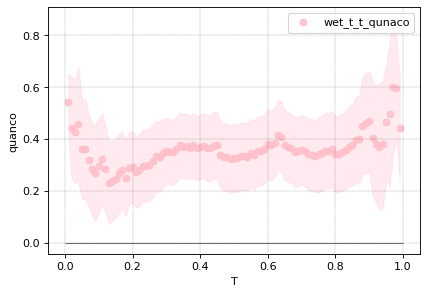

In [35]:
fig, ax = plt.subplots(dpi=80)
ax.scatter(quantiles, va_wet['wet_t'],  c="pink", alpha=0.9, marker='o',label="wet_t_t_qunaco")
ax.fill_between(quantiles, va_wet['wet_t_up'], va_wet['wet_t_down'], alpha=0.3,color='pink')
ax.set_xlabel("T")
ax.set_ylabel("quanco")
ax.legend()
ax.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k')
ax.hlines(y = 0,xmin=0,xmax=1,color='k',linestyles='-',lw=0.5)
#plt.savefig('wet_t_quanco.pdf')
plt.rcParams["figure.figsize"] = (6,4)
plt.show()

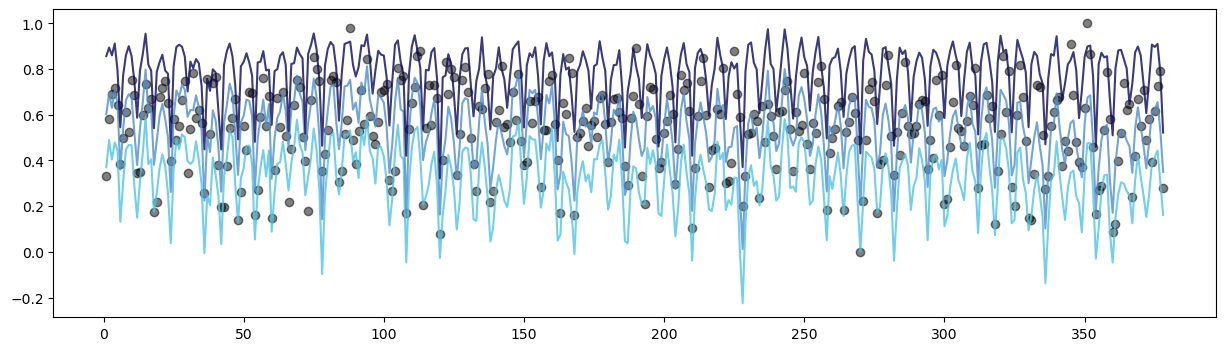

In [20]:
fig, ax = plt.subplots(dpi=100)
year = np.arange(1,379,1)
plt.rcParams["figure.figsize"] = (15,4)
ax.scatter(year,prrr_wet,c='k',alpha=0.5)
for i,color in zip([5,50,95],['#4dc3e6','#4f8fcb','#0a0a57']):
    
    ax.plot(year, 
            (va_wet['wet_ubob'][i-1]*normalization(np.nanmean(arr_ubob_wet,axis=(1,2)))+
             va_wet['wet_vscs'][i-1]*normalization(np.nanmean(arr_vSCS_wet,axis=(1,2)))+
             va_wet['wet_gphscs'][i-1]*normalization(np.nanmean(arr_gphSCS_wet,axis=(1,2)))+
             va_wet['wet_t'][i-1]*normalization(np.nanmean(arr_t_wet,axis=(1,2)))+va_wet['intercept'][i-1])
            , '-',color=color,alpha=0.8)

# dry season array variation construction

In [21]:
# normalizaton
prrr_dry = normalization(np.nanmean(dry_season_p,axis=(1,2)))
X_dry = np.column_stack((normalization(np.nanmean(arr_ubob_dry,axis=(1,2))),
                     normalization(np.nanmean(arr_vSCS_dry,axis=(1,2))),
                    normalization(np.nanmean(arr_gphSCS_dry,axis=(1,2))),
                    normalization(np.nanmean(arr_t_dry,axis=(1,2)))))

In [22]:
# Fit the multivariate quantile regression model
#mod = sm.QuantReg(np.nanmean(wet_season_p,axis=(1,2)), sm.add_constant(X))
mod = sm.QuantReg(prrr_dry, sm.add_constant(X_dry))

quantiles = np.arange(0.01,1,0.01)
models = []
params = []
x1_coef,x2_coef,x3_coef,x4_coef = [],[],[],[]
x1_up,x2_up,x3_up,x4_up = [],[],[],[]
x1_down,x2_down,x3_down,x4_down = [],[],[],[]
intercept = []

for qt in quantiles:
    res = mod.fit(q=qt)
    res.params[1:]
    x1_coef.append(res.params[1])
    x2_coef.append(res.params[2])
    x3_coef.append(res.params[3])
    x4_coef.append(res.params[4])
    intercept.append(res.params[0])
    
    x1_up.append(res.conf_int()[1][0])
    x2_up.append(res.conf_int()[2][0])
    x3_up.append(res.conf_int()[3][0])
    x4_up.append(res.conf_int()[4][0])
    
    x1_down.append(res.conf_int()[1][1])
    x2_down.append(res.conf_int()[2][1])
    x3_down.append(res.conf_int()[3][1])
    x4_down.append(res.conf_int()[4][1])
    
    
    
va_dry = pd.DataFrame({'q_t':np.arange(0.01,1,0.01),
                       'dry_ubob':x1_coef,
                       'dry_vscs':x2_coef,
                       'dry_gphscs':x3_coef,
                       'dry_t':x4_coef,
                       'intercept':intercept,
'dry_ubob_up':x1_up,'dry_vscs_up':x2_up,'dry_gphscs_up':x3_up,'dry_t_up':x4_up,
'dry_ubob_down':x1_down,'dry_vscs_down':x2_down,'dry_gphscs_down':x3_down,'dry_t_down':x4_down})

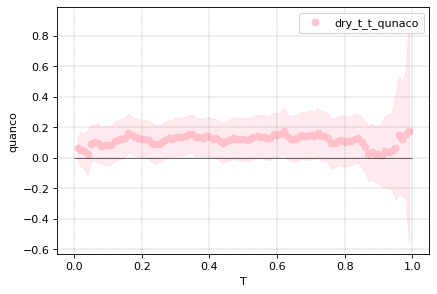

In [36]:
fig, ax = plt.subplots(dpi=80)
ax.scatter(quantiles, va_dry['dry_t'],  c="pink", alpha=0.9, marker='o',label="dry_t_t_qunaco")
ax.fill_between(quantiles, va_dry['dry_t_up'], va_dry['dry_t_down'], alpha=0.3,color='pink')
ax.set_xlabel("T")
ax.set_ylabel("quanco")
ax.legend()
ax.grid(linestyle='--',linewidth=0.3,alpha=0.5,color='k')
ax.hlines(y = 0,xmin=0,xmax=1,color='k',linestyles='-',lw=0.5)
plt.rcParams["figure.figsize"] = (6,4)
#plt.savefig('wet_t_quanco.pdf')
plt.show()

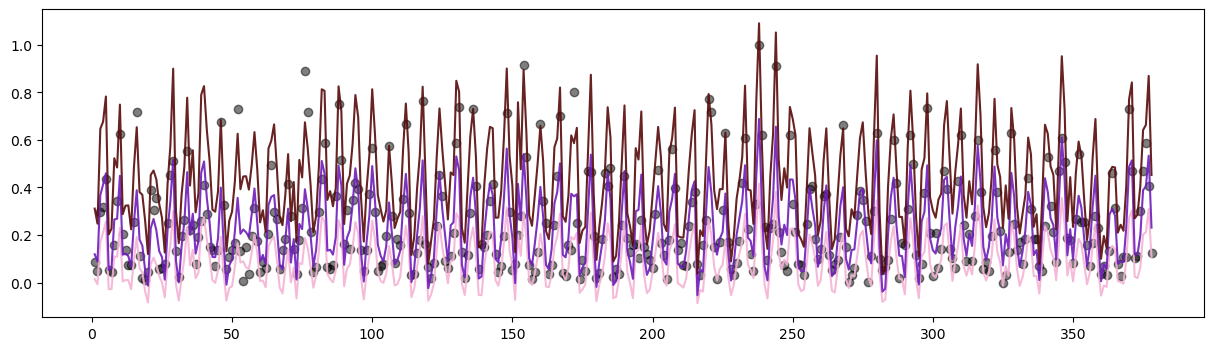

In [37]:
color = ['#570a0a',]
plt.rcParams["figure.figsize"] = (15,4)
fig, ax = plt.subplots(dpi=100)
year = np.arange(1,379,1)
ax.scatter(year,prrr_dry,c='k',alpha=0.5)
for i,color in zip([5,50,95],['#f5b3d5','#6f1dbc','#570a0a',]):
        ax.plot(year, 
            (va_dry['dry_ubob'][i-1]*normalization(np.nanmean(arr_ubob_dry,axis=(1,2)))+
             va_dry['dry_vscs'][i-1]*normalization(np.nanmean(arr_vSCS_dry,axis=(1,2)))+
             va_dry['dry_gphscs'][i-1]*normalization(np.nanmean(arr_gphSCS_dry,axis=(1,2)))+
             va_dry['dry_t'][i-1]*normalization(np.nanmean(arr_t_dry,axis=(1,2)))+va_dry['intercept'][i-1])
            , '-',color=color,alpha=0.9)

## continue from here

# Trend coefficients with GPH, uBOB, vSCS, LMRBT as covariate derived from the classic quantile regression

In [38]:
from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
clist=['#6eed8f','#d0a0fc',
       '#fec588',
       '#f781be']
newcmp1 = LinearSegmentedColormap.from_list('chaos',clist)

In [39]:
from plot.auto_cbar import fromFigToColorBar
new_c,_ = fromFigToColorBar('1680246450028.jpg',4,-1,inputPcs=4)

## wet season variable spacial distrubution

In [40]:
wet_season_yp = arr_prec_wet

In [60]:
names = locals()
quantiles = (5,10,50,90,95)

for qt in quantiles:
    names['w_vari'+str(qt)]=[0,0,0,0]
    for lat in range(0,102):
        for lon in range(0,61):
            X_wet_v = np.column_stack((normalization(np.nanmean(arr_ubob_wet,axis=(1,2))),
                     normalization(np.nanmean(arr_vSCS_wet,axis=(1,2))),
                    normalization(np.nanmean(arr_gphSCS_wet,axis=(1,2))),
                    normalization(arr_t_wet[:,lat,lon])))
            if isnan(arr_prec_wet[:,lat,lon][1]):
                names['w_vari'+str(qt)] = np.row_stack((names['w_vari'+str(qt)],[np.nan,np.nan,np.nan,np.nan,]))
            
            else:
                mod = sm.QuantReg(normalization(arr_prec_wet[:,lat,lon]), sm.add_constant(X_wet_v))
                
                #quantiles = (0.05,0.5,0.95)
                
                res = mod.fit(q = qt/100 )
                names['w_vari'+str(qt)]= np.row_stack((names['w_vari'+str(qt)],res.params[1:]))
                
    names['w_vari'+str(qt)] = names['w_vari'+str(qt)][1:].reshape(102,61,4)

            
 #############################################################################################


In [68]:
w_vari = w_vari10
wet_i = []
for lat in range(0,102):
    for lon in range(0,61):
        if isnan(np.abs(w_vari)[lat,lon,1]):
            wet_i = np.append(wet_i,np.nan)
        else:
            wet_i = np.append(wet_i,np.argmax(np.abs(w_vari)[lat,lon,]))

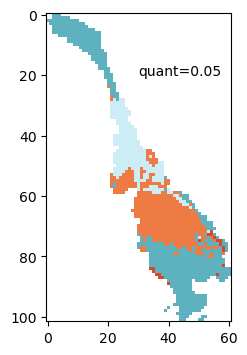

In [69]:
plt.imshow(wet_i.reshape(102,61),cmap=new_c)
plt.text(30, 20, 'quant=0.05')
plt.rcParams["figure.figsize"] = (3,4)
#plt.colorbar()

### dry season variable spacial distrubution

In [70]:
dry_season_yp = arr_prec_dry

In [71]:
names = locals()
quantiles = (5,10,50,90,95)

for qt in quantiles:
    names['d_vari'+str(qt)]=[0,0,0,0]
    for lat in range(0,102):
        for lon in range(0,61):
            X_dry_v = np.column_stack((normalization(np.nanmean(arr_ubob_dry,axis=(1,2))),
                     normalization(np.nanmean(arr_vSCS_dry,axis=(1,2))),
                    normalization(np.nanmean(arr_gphSCS_dry,axis=(1,2))),
                    normalization(arr_t_dry[:,lat,lon])))
            if isnan(arr_prec_dry[:,lat,lon][1]):
                names['d_vari'+str(qt)] = np.row_stack((names['d_vari'+str(qt)],[np.nan,np.nan,np.nan,np.nan,]))
            
            else:
                mod = sm.QuantReg(normalization(arr_prec_dry[:,lat,lon]), sm.add_constant(X_dry_v))
                
                #quantiles = (0.05,0.5,0.95)
                
                res = mod.fit(q = qt/100 )
                names['d_vari'+str(qt)]= np.row_stack((names['d_vari'+str(qt)],res.params[1:]))
                
    names['d_vari'+str(qt)] = names['d_vari'+str(qt)][1:].reshape(102,61,4)

In [72]:
d_vari = d_vari95

dry_i = []
for lat in range(0,102):
    for lon in range(0,61):
        if isnan(np.abs(d_vari)[lat,lon,1]):
            dry_i = np.append(dry_i,np.nan)
        else:
            dry_i = np.append(dry_i,np.argmax(np.abs(d_vari)[lat,lon,]))

Text(30, 20, 'quant=0.05')

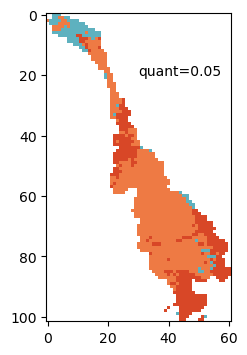

In [59]:
plt.imshow(dry_i.reshape(102,61),cmap=new_c)
plt.text(30, 20, 'quant=0.05')
#plt.colorbar()

## contribution of each variables

Text(30, 20, 'quant=0.05')

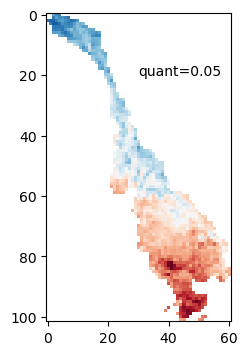

In [127]:

d_vari = w_vari5
plt.imshow(d_vari[:,:,3],cmap='RdBu',vmin=-1,vmax=1)
# in the {d_vari[:,:,0]} 0 means uBOB, 1 means vSCS, 
# 2 means Geopotential and 3 means local 2m tempreature
plt.text(30, 20, 'quant=0.05')
#plt.colorbar()